**After this laboratory you should be able to**
- Explain **generative models** and the motivation for them. Understand the properties we want to look at and how real world graphs behave
- Understand some classic topologies.
- Explain **Erdos renyi model** (how to generate) and how it compares to real world graphs
- Understand a random mesh

In [3]:
import itertools
import os
import random
import sys

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import scipy.stats as st
from tqdm import tqdm

In [4]:
# Append parent path so we can access the `utils` package. It's a workaround.
parent_dir = os.path.abspath(os.path.join(".."))
if not parent_dir in sys.path:
    sys.path.append(parent_dir)

from utils.utils import load_graph

## Utils

In [5]:
def giant_component(G: nx.Graph) -> nx.Graph:
    """Return the biggest component of a graph

    Parameters:
    -----------
    G: nx.Graph
        Input graph

    Returns:
    --------
    biggest component: nx.graph
    """

    # Get all connected components and sort them by the number of nodes
    Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
    # Get the subgraph corresponding to the first giant component
    G0 = G.subgraph(Gcc[0])
    return G0


def connectivity_perc(G: nx.Graph) -> float:
    """Returns the percentage of nodes found in the giant component

    Parameters:
    -----------
    G: nx.Graph
        Input graph

    Returns:
    --------
        :float
    """
    G0 = giant_component(G)
    connectivity_perc = G0.number_of_nodes() / G.number_of_nodes()
    return connectivity_perc


def average_clustering(G: nx.Graph) -> float:
    return np.mean(list(nx.clustering(G).values()))


def average_degree(G: nx.Graph) -> float:
    return sum(G.degree(n) for n in G.nodes) / len(G.nodes)

In [6]:
def average_shortest_path_length_sampled(G: nx.Graph, n_samples: int = 500) -> float:
    """
    Return the average shortest path length of a graph
    by sampling nodes and calculating the shortest path between them.
    If the number of samples is higher than the number of edges use networkx intrinsic function

    Parameters:
    -----------
        G: nx.Graph
            Input graph
        n_samples: int
            number of node pairs to sample

    Returns:
    --------
        average shortes path length :int

    """
    G0 = giant_component(G)
    if n_samples >= len(G0.edges):
        return nx.average_shortest_path_length(G0)

    # Get all possible pairs of 2 nodes
    possible_pairs = np.array(list(itertools.combinations(G0.nodes, 2)))
    # Select `n_samples` pairs indexes
    idxs = np.random.choice(len(possible_pairs), n_samples, replace=False)
    # Get the pairs
    pairs = possible_pairs[idxs]

    lengths = []
    # For each pair, calculate the shortest path.
    for u, v in pairs:
        length = nx.shortest_path_length(G0, source=u, target=v)
        lengths.append(length)
    # return the mean
    return np.mean(length)

In [7]:
def print_stats(G, n_samples=500):
    print(f"{G.number_of_nodes() = :}")
    print(f"{G.number_of_edges() = }")
    print(f"{average_degree(G) = :.2f}")
    print(f"{average_clustering(G) = :.4f}")
    print(f"{connectivity_perc(G) = :.2f}")
    print(f"{average_shortest_path_length_sampled(G, n_samples) = }")

In [8]:
# Download and load graphs.
G_pgrid = load_graph("power-us-grid")
G_arvix = load_graph("arvix")
G_fb = load_graph("facebook")
G_wiki = load_graph("wiki")

In [9]:
average_clustering(G_pgrid)

np.float64(0.08010361108159714)

In [10]:
nx.average_clustering(G_pgrid)

0.08010361108159714

In [11]:
print_stats(G_pgrid)
print()
print_stats(G_arvix)
print()
print_stats(G_fb)
print()
print_stats(G_wiki)
print()

G.number_of_nodes() = 4941
G.number_of_edges() = 6594
average_degree(G) = 2.67
average_clustering(G) = 0.0801
connectivity_perc(G) = 1.00
average_shortest_path_length_sampled(G, n_samples) = np.float64(17.0)

G.number_of_nodes() = 5242
G.number_of_edges() = 14496
average_degree(G) = 5.53
average_clustering(G) = 0.5296
connectivity_perc(G) = 0.79
average_shortest_path_length_sampled(G, n_samples) = np.float64(5.0)

G.number_of_nodes() = 4039
G.number_of_edges() = 88234
average_degree(G) = 43.69
average_clustering(G) = 0.6055
connectivity_perc(G) = 1.00
average_shortest_path_length_sampled(G, n_samples) = np.float64(1.0)

G.number_of_nodes() = 7115
G.number_of_edges() = 100762
average_degree(G) = 28.32
average_clustering(G) = 0.1409
connectivity_perc(G) = 0.99
average_shortest_path_length_sampled(G, n_samples) = np.float64(4.0)



# Generative models

**Problem: Graph generation**  
We are trying to generate graphs that are similar to real world graphs.

**Why do we study them?**
- *Insights* - understand how graphs can be formed
- *Predictions* - predict how the graph will evolve in the future
- *Simulations* - Understand the processes and use them to generate new graph instances
- *Anomaly detection* - We can decide if a graph is normal/ abnormal. We can use them as a reference point against real world  graphs to detect abnormalities -- https://en.wikipedia.org/wiki/Null_model

**Important properties**
- Degree distribution / average degree $P(k), k$
- Clustering coefficient $C_i =  \dfrac {2e_i} {k_i(k_i-1)}$ -- *Friend of a friend is my friend*
- Connected components -- How large is the connected component (% of total nodes)
- Average shortest path length $d$ -- on average how many hops it takes from a node to another


**Real world graph**
- Degree distribution: Look plots
- Clustering coeff -- Quite high (we'll compare to our models) and understand why
- Connected components -- >90% belong to the largest component
- Shortest path length -- Pretty low (6 degrees of separation) $\to$ small world phenomena

<Figure size 2000x1000 with 0 Axes>

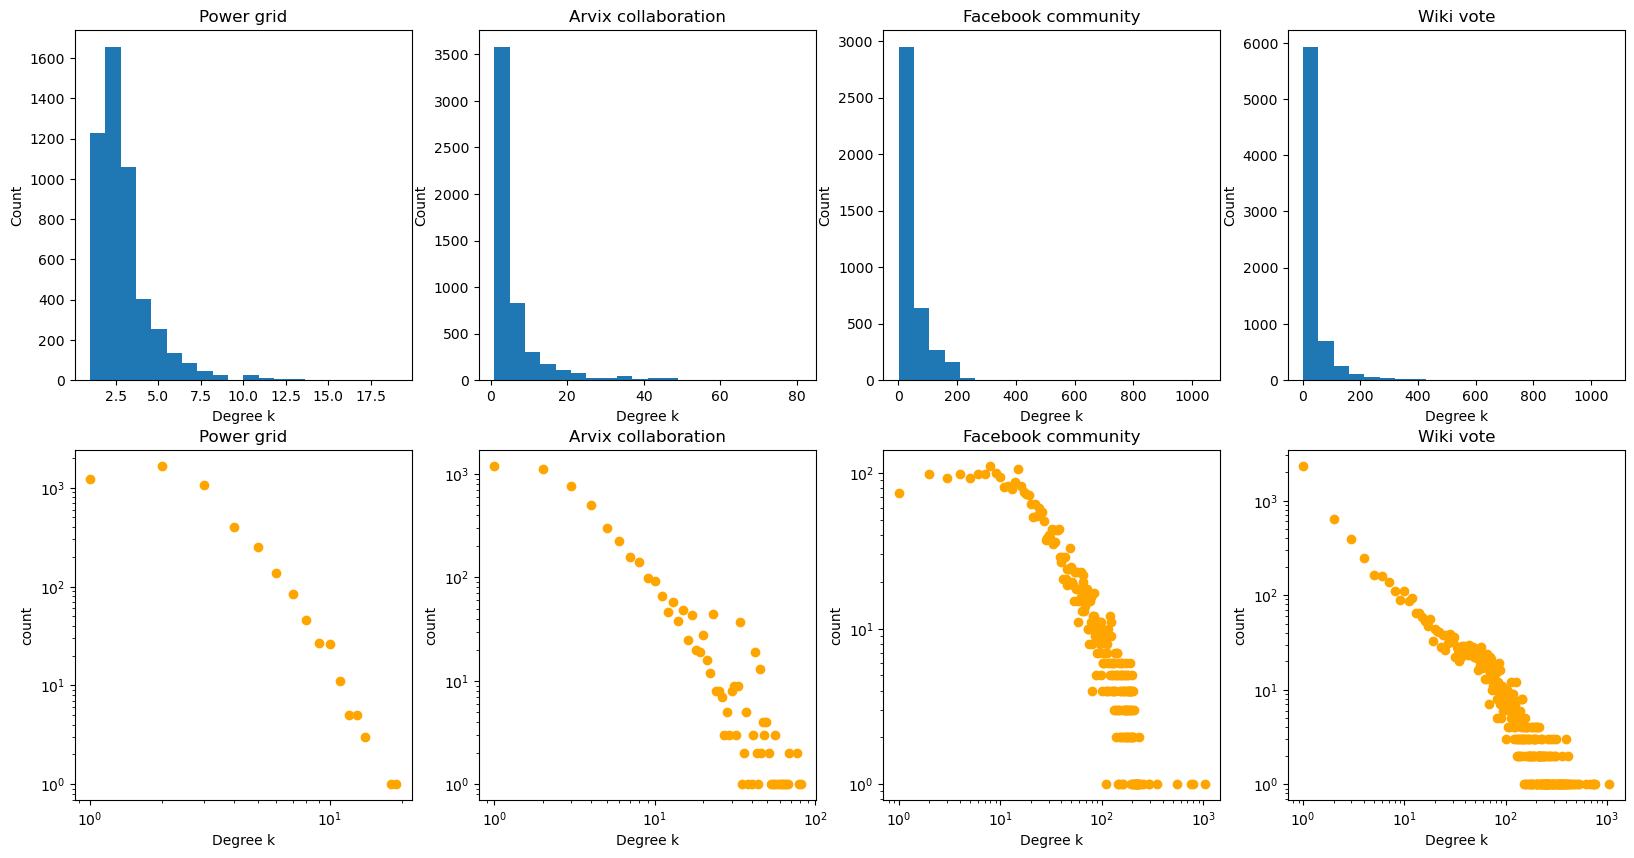

In [12]:
plt.figure(figsize=(4 * 5, 10))
real_graphs = [G_pgrid, G_arvix, G_fb, G_wiki]
titles = ["Power grid", "Arvix collaboration", "Facebook community", "Wiki vote"]

i = 1
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
for i, (G, title) in enumerate(zip(real_graphs, titles)):
    # Plot the distribution
    axs[0][i].set_title(title)
    axs[0][i].hist([G.degree(u) for u in G.nodes], bins=20)
    axs[0][i].set_xlabel("Degree k")
    axs[0][i].set_ylabel("Count")

    # PLot the distribution but on log scale
    values, counts = np.unique([G.degree(n) for n in G.nodes], return_counts=True)
    axs[1][i].scatter(values, counts, c="orange")
    axs[1][i].set_title(title)
    axs[1][i].set_xlabel("Degree k")
    axs[1][i].set_ylabel("count")
    axs[1][i].set_xscale("log")
    axs[1][i].set_yscale("log")

plt.show()

# Classic topologies

**Fully connected**  
Every 2 nodes are connected $\to \dfrac {n(n-1)} 2$  edges
- $-$ Costly, impractical, *unrealistic* for large newtorks
- $+$ Highest speeds,
- $+$ most *politically correct* in terms of value spreading
	- No tempering, a node can influence any nodes


**Linear**  
Each node is connected to 2 neighbours $\to n$ edges
- $+$ cost effective
- $-$ high tempering (think about how news propagate through this network), unrealistic

**Star**  
Central hub $\to n-1$ links
- Hub *redistributes messages to all nodes*

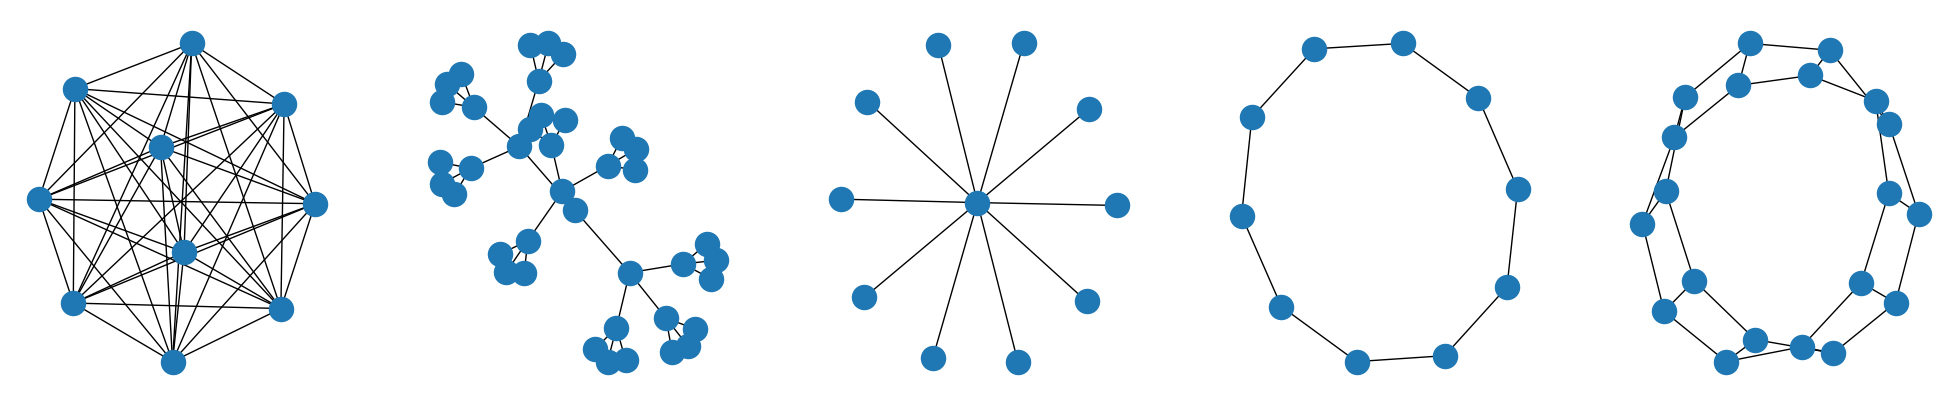

In [13]:
n = 10
children = 3
height = 3

G_list = [
    nx.complete_graph(n),
    nx.balanced_tree(children, height),
    nx.star_graph(n),
    nx.cycle_graph(n),
    nx.circular_ladder_graph(n),
]

fig, axs = plt.subplots(1, len(G_list), figsize=(5 * len(G_list), 5))
for i, G in enumerate(G_list):
    nx.draw(G, ax=axs[i])

# Erdos-Renyi model
- [Wikipedia entry](https://en.wikipedia.org/wiki/Erd%C5%91s%E2%80%93R%C3%A9nyi_model)


$G_{np}$: undirected graph with $n$ nodes where each edge $(u, v)$ appears with probability $p$

**How to generate**
- Each pair of nodes is connected with a probability $p$
- Start with $n$ nodes. For each node pair and decide with probability $p$ to connect them.

**Properties**
- Not uniquely determined -- Graph is a result of a random process
- variable number of links
- nodes may remain disconnected

Average number of edges $$\langle E \rangle = p \cdot e_{max} = p \cdot \dfrac {n(n-1)} {2}$$

### Average degree
Average degree distribution: Binomial
$$ P(k) = {n-1 \choose k} \cdot {p^k} \cdot {(1-p)^{n-1-k}}$$
- ${n-1 \choose k}$ = Select $k$ nodes out of $n-1$
- $p^k$ probability of having $k$ edges
- $(1-p)^{n-1-k}$ Probability of missing the rest of the $n-1-k$ edges

Therefore the average degree is
$$\boxed{ \langle k \rangle = \dfrac {2\langle e \rangle} n = p \cdot (n-1)}$$

Therefore given a real world graph with an average degree $\langle k \rangle$ we can calculate the probability of an equivalent random generated graph with $$p = \dfrac{\langle k \rangle} {n - 1}$$

In [14]:
def erdos_renyi_graph(n: int, p: float, directed: bool = False):
    """
    Generate an Erdos-Renyi graph

    Args:
        n: int
            number of nodes
        p: float
            probability of an edge to be connected
        directed: bool
            True -- the returned graph is directed

    Returns:
        :nx.Graph or nx.DiGraph
    """
    if directed:
        G = nx.DiGraph()
    else:
        G = nx.Graph()
    # Add the `n` nodes
    G.add_nodes_from(range(n))
    # Generate All possible edges
    possible_edges = itertools.combinations(range(n), 2)

    for u, v in possible_edges:  # for each possible edge
        if random.random() < p:  # flip a biased coin
            G.add_edge(u, v)

    return G

In [15]:
# Get (n, p) based on wiki graph
n = G_wiki.number_of_nodes()
p = average_degree(G_wiki) / (n - 1)
print(f"{p = }")


G = erdos_renyi_graph(n, p)
# G = nx.erdos_renyi_graph(n, p)
# nx.draw(G)

# Computed and expected num edges and degree
print(G.number_of_edges(), p * n * (n - 1) / 2)
print(average_degree(G), p * (n - 1))

p = 0.003981420144693063
100738 100762.0
28.317076598735067 28.323822909346454


### Degree distribution is binomial
- ${n-1 \choose k}$ = Select $k$ nodes out of $n-1$
- $p^k$ probability of having $k$ edges
- $(1-p)^{n-1-k}$ Probability of missing the rest of the $n-1-k$ edges

Binomial comes close to Poisson when n is large

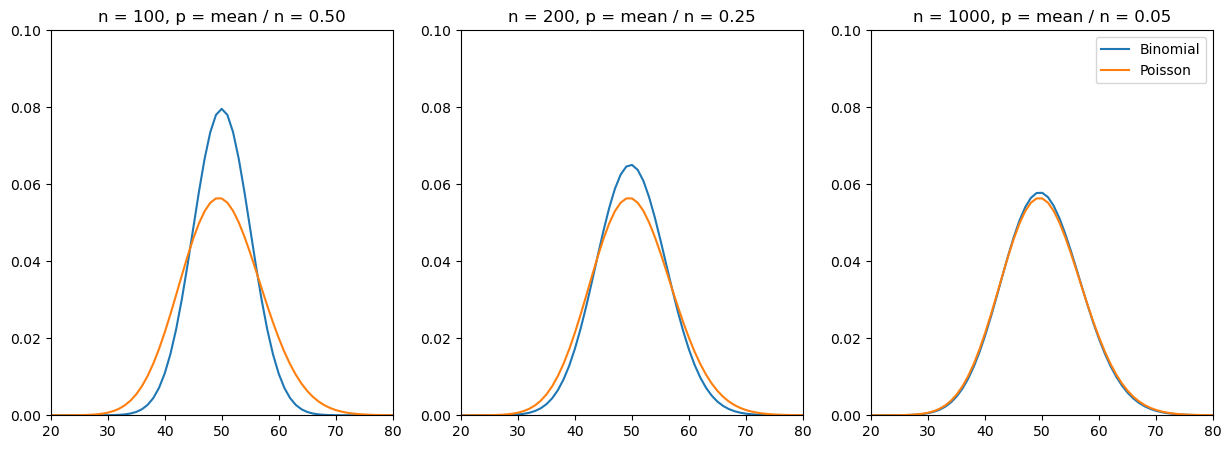

In [16]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i, [n, mean] in enumerate([[100, 50], [200, 50], [1000, 50]]):
    axs[i].plot(st.binom(n, mean / n).pmf(np.arange(100)), label="Binomial")
    axs[i].plot(st.poisson(mean).pmf(np.arange(100)), label="Poisson")
    axs[i].set_xlim(20, 80)
    axs[i].set_ylim(0, 0.1)
    axs[i].set_title(f"{n = }, p = {mean / n = :.2f}")
plt.legend(loc="upper right");

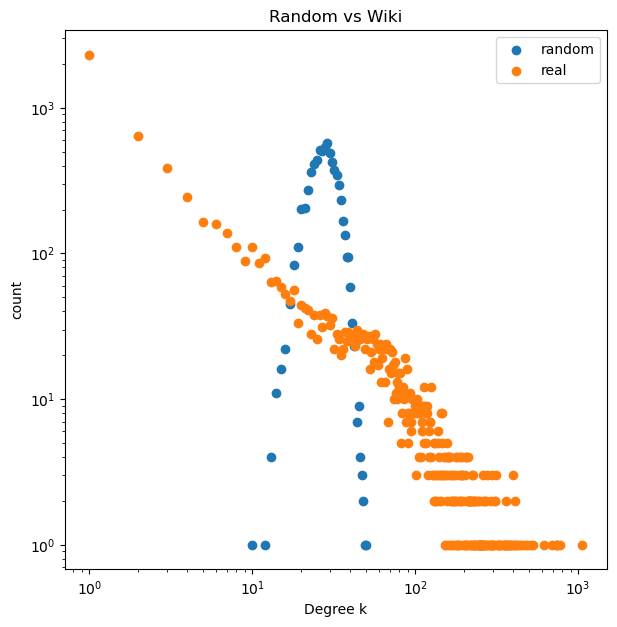

In [17]:
plt.figure(figsize=(7, 7))

# Plot degrees of erdos-renyi random graph
values, counts = np.unique([G.degree(n) for n in G.nodes], return_counts=True)
plt.scatter(values, counts, label="random")

# Plot degrees of a real wiki graph random graph
values, counts = np.unique([G_wiki.degree(n) for n in G_wiki.nodes], return_counts=True)
plt.scatter(values, counts, label="real")
plt.xlabel("Degree k")
plt.ylabel("count")
plt.xscale("log")
plt.yscale("log")

plt.title("Random vs Wiki")
plt.legend()
plt.show()

## Notice that real networks are not poisson / binomial

### Clustering coefficient
In a completely random graph the prob that 2 neighbous are neighbours betwen themselves is no greater than the prob that 2 randomly chosen nodes from the network are connected
- Therefore we usually have no clustering
$$C_i = p = \dfrac {\langle k \rangle} {n-1} \ll 1$$

In [18]:
# Compute the mean clustering coefficient of the erdos-renyi graph and compare it with the probability
print(np.mean(list(nx.clustering(G).values())))
print(p)

0.004002798242000533
0.003981420144693063


### Giant components

Giant component will start to emerge when $\langle k \rangle > 1$

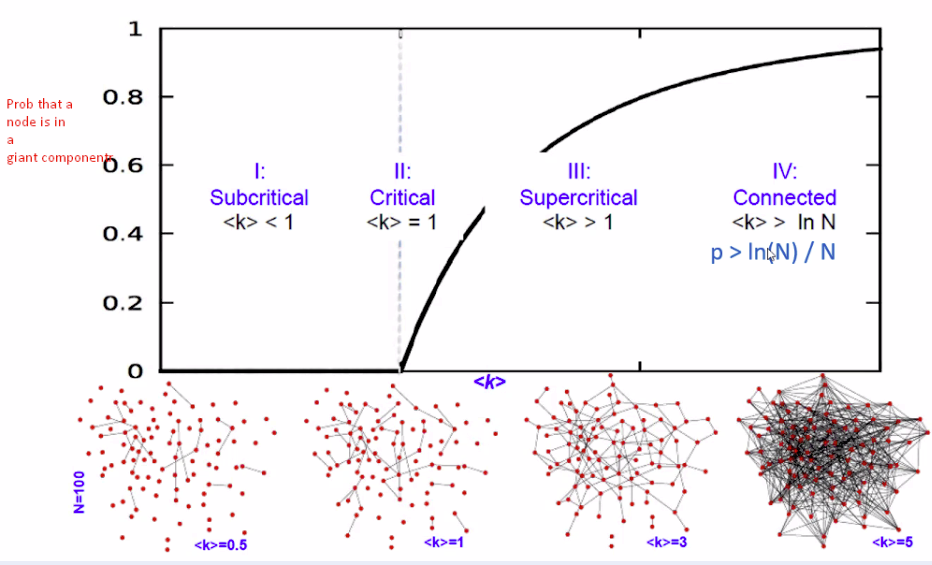

In [19]:
np.linspace(0.1, np.log(n), 50)

array([0.1       , 0.23893378, 0.37786756, 0.51680134, 0.65573512,
       0.79466891, 0.93360269, 1.07253647, 1.21147025, 1.35040403,
       1.48933781, 1.62827159, 1.76720537, 1.90613916, 2.04507294,
       2.18400672, 2.3229405 , 2.46187428, 2.60080806, 2.73974184,
       2.87867562, 3.01760941, 3.15654319, 3.29547697, 3.43441075,
       3.57334453, 3.71227831, 3.85121209, 3.99014587, 4.12907965,
       4.26801344, 4.40694722, 4.545881  , 4.68481478, 4.82374856,
       4.96268234, 5.10161612, 5.2405499 , 5.37948369, 5.51841747,
       5.65735125, 5.79628503, 5.93521881, 6.07415259, 6.21308637,
       6.35202015, 6.49095394, 6.62988772, 6.7688215 , 6.90775528])

In [20]:
n = 200  # number of nodes
ks = np.linspace(0.1, np.log(n), 50)  # 50 average degrees equally spaced betwen .1 and log(n)
ps = [k / (n - 1) for k in ks]  # compute probabilities based on degree

num_experiments = 10  # run 10 experiments
all_gs_sizes = []
for p in tqdm(ps):
    # Run multiple experiments for each probability
    gs_sizes = []
    for _ in range(num_experiments):
        G = erdos_renyi_graph(n, p)
        gs_sizes.append(connectivity_perc(G))  # % of the biggest component from all
    all_gs_sizes.append(gs_sizes)


all_gs_sizes = np.array(all_gs_sizes)

100%|██████████| 50/50 [00:01<00:00, 39.35it/s]


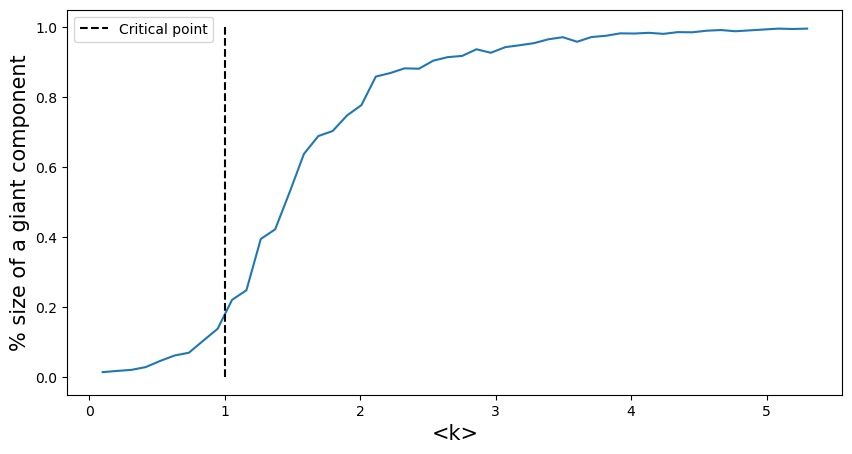

In [21]:
# Plot experiments
plt.figure(figsize=(10, 5))

## Plot all experiments
# for i in range(num_experiments):
#     plt.plot(ks, all_gs_sizes[:, i])

# Plot the mean of all
plt.plot(ks, np.mean(all_gs_sizes, axis=1))

plt.plot([1, 1], [0, 1], "k--", label="Critical point")

plt.xlabel("<k>", size=15)
plt.ylabel("% size of a giant component", size=15)
plt.legend()
plt.show()

### Shortest path

$\mathcal O(\log n)$

### vs Real

- $+$ Average path length is similar
- $+$ Real networks are usually *supercritical* $1 < \langle k \rangle < \ln n$ => Giant component exists
- $-$ Degree distribution doesn't mirror real life
- $-$ Clustering coefficient is very small in $G_{np}$ random graphs but orders of magnitude bigger in real life

In [ ]:
n = G_arvix.number_of_nodes()
p = average_degree(G_arvix) / (n - 1)
print(f"{p = }")

G = erdos_renyi_graph(n, p)

print("Real")
print_stats(G_arvix, 250)
print("Erdos-renyi")
print_stats(G, 250)

p = 0.001055278280507905
Real
G.number_of_nodes() = 5242
G.number_of_edges() = 14496
average_degree(G) = 5.53
average_clustering(G) = 0.5296
connectivity_perc(G) = 0.79


In [ ]:
nx.average_shortest_path_length(giant_component(G_arvix))

6.049380016182999

In [2]:
nx.average_shortest_path_length(G_pgrid)

NameError: name 'nx' is not defined

# Geometric mesh network

Due to physical proximity, is fundamental to human organization

Every node has coordinates   
Let $(x_i, y_i)$,  $(x_j, y_j)$ be two nodes $n_i, n_j$  
They will connect with **probability** $p$ if distance $d(n_i, n_j) < r$  

In [ ]:
from scipy.spatial.distance import pdist


def random_mesh_graph(n, r, p):
    positions = [[random.random(), random.random()] for _ in range(n)]
    possible_edges = itertools.combinations(range(n), 2)
    pdists = pdist(positions)
    # print(pdists.shape, len(possible_edges))

    G = nx.Graph()

    for e, d in zip(possible_edges, pdists):
        # Alternatively you can make p = f(d) such as p = pow(e, -d)
        if d < r and random.random() < p:
            G.add_edge(*e)

    return G

In [ ]:
# n = 300
n = G_pgrid.number_of_nodes()
p = 0.5
r = 0.05
G = random_mesh_graph(n, r, p)
# nx.draw(G, node_size = 20) # draw only for smaller n

print(average_degree(G))
nx.density(G)

18.5986642380085


0.0037649117890705464

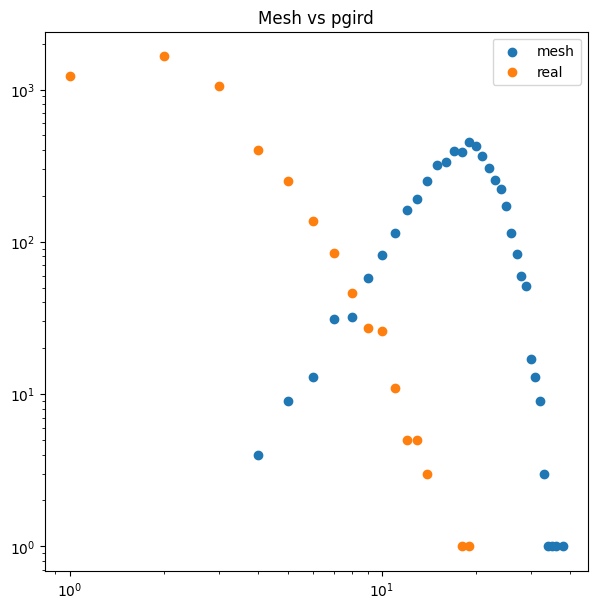

In [ ]:
plt.figure(figsize=(7, 7))
values, counts = np.unique([G.degree(n) for n in G.nodes], return_counts=True)
plt.scatter(values, counts, label="mesh")

values, counts = np.unique([G_pgrid.degree(n) for n in G_pgrid.nodes], return_counts=True)
plt.scatter(values, counts, label="real")
plt.xscale("log")
plt.yscale("log")

plt.title("Mesh vs pgird")
plt.legend()

plt.show()